# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.fastscape_ext import IR12Speciation, DD03Speciation
from paraspec.fastscape_ext import FastscapeElevationTrait, FastscapePrecipitationTrait
from paraspec.fastscape_ext import CompoundEnvironment, ElevationEnvField1
from paraspec.fastscape_ext import PrecipitationField1
from paraspec.fastscape_ext import RandomSeedFederation
from orographic_precipitation.fastscape_ext import OrographicPrecipitation, OrographicDrainageDischarge

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev1':FastscapeElevationTrait,
    'trait_prep1':FastscapePrecipitationTrait,
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'precip1': PrecipitationField1,
    'random': RandomSeedFederation,
    'precipitation': OrographicPrecipitation,
    'drainage': OrographicDrainageDischarge
})

model

<xsimlab.Model (24 processes, 41 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
init_erosion
flow
precipitation
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] background, non-orographic precipit...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fal

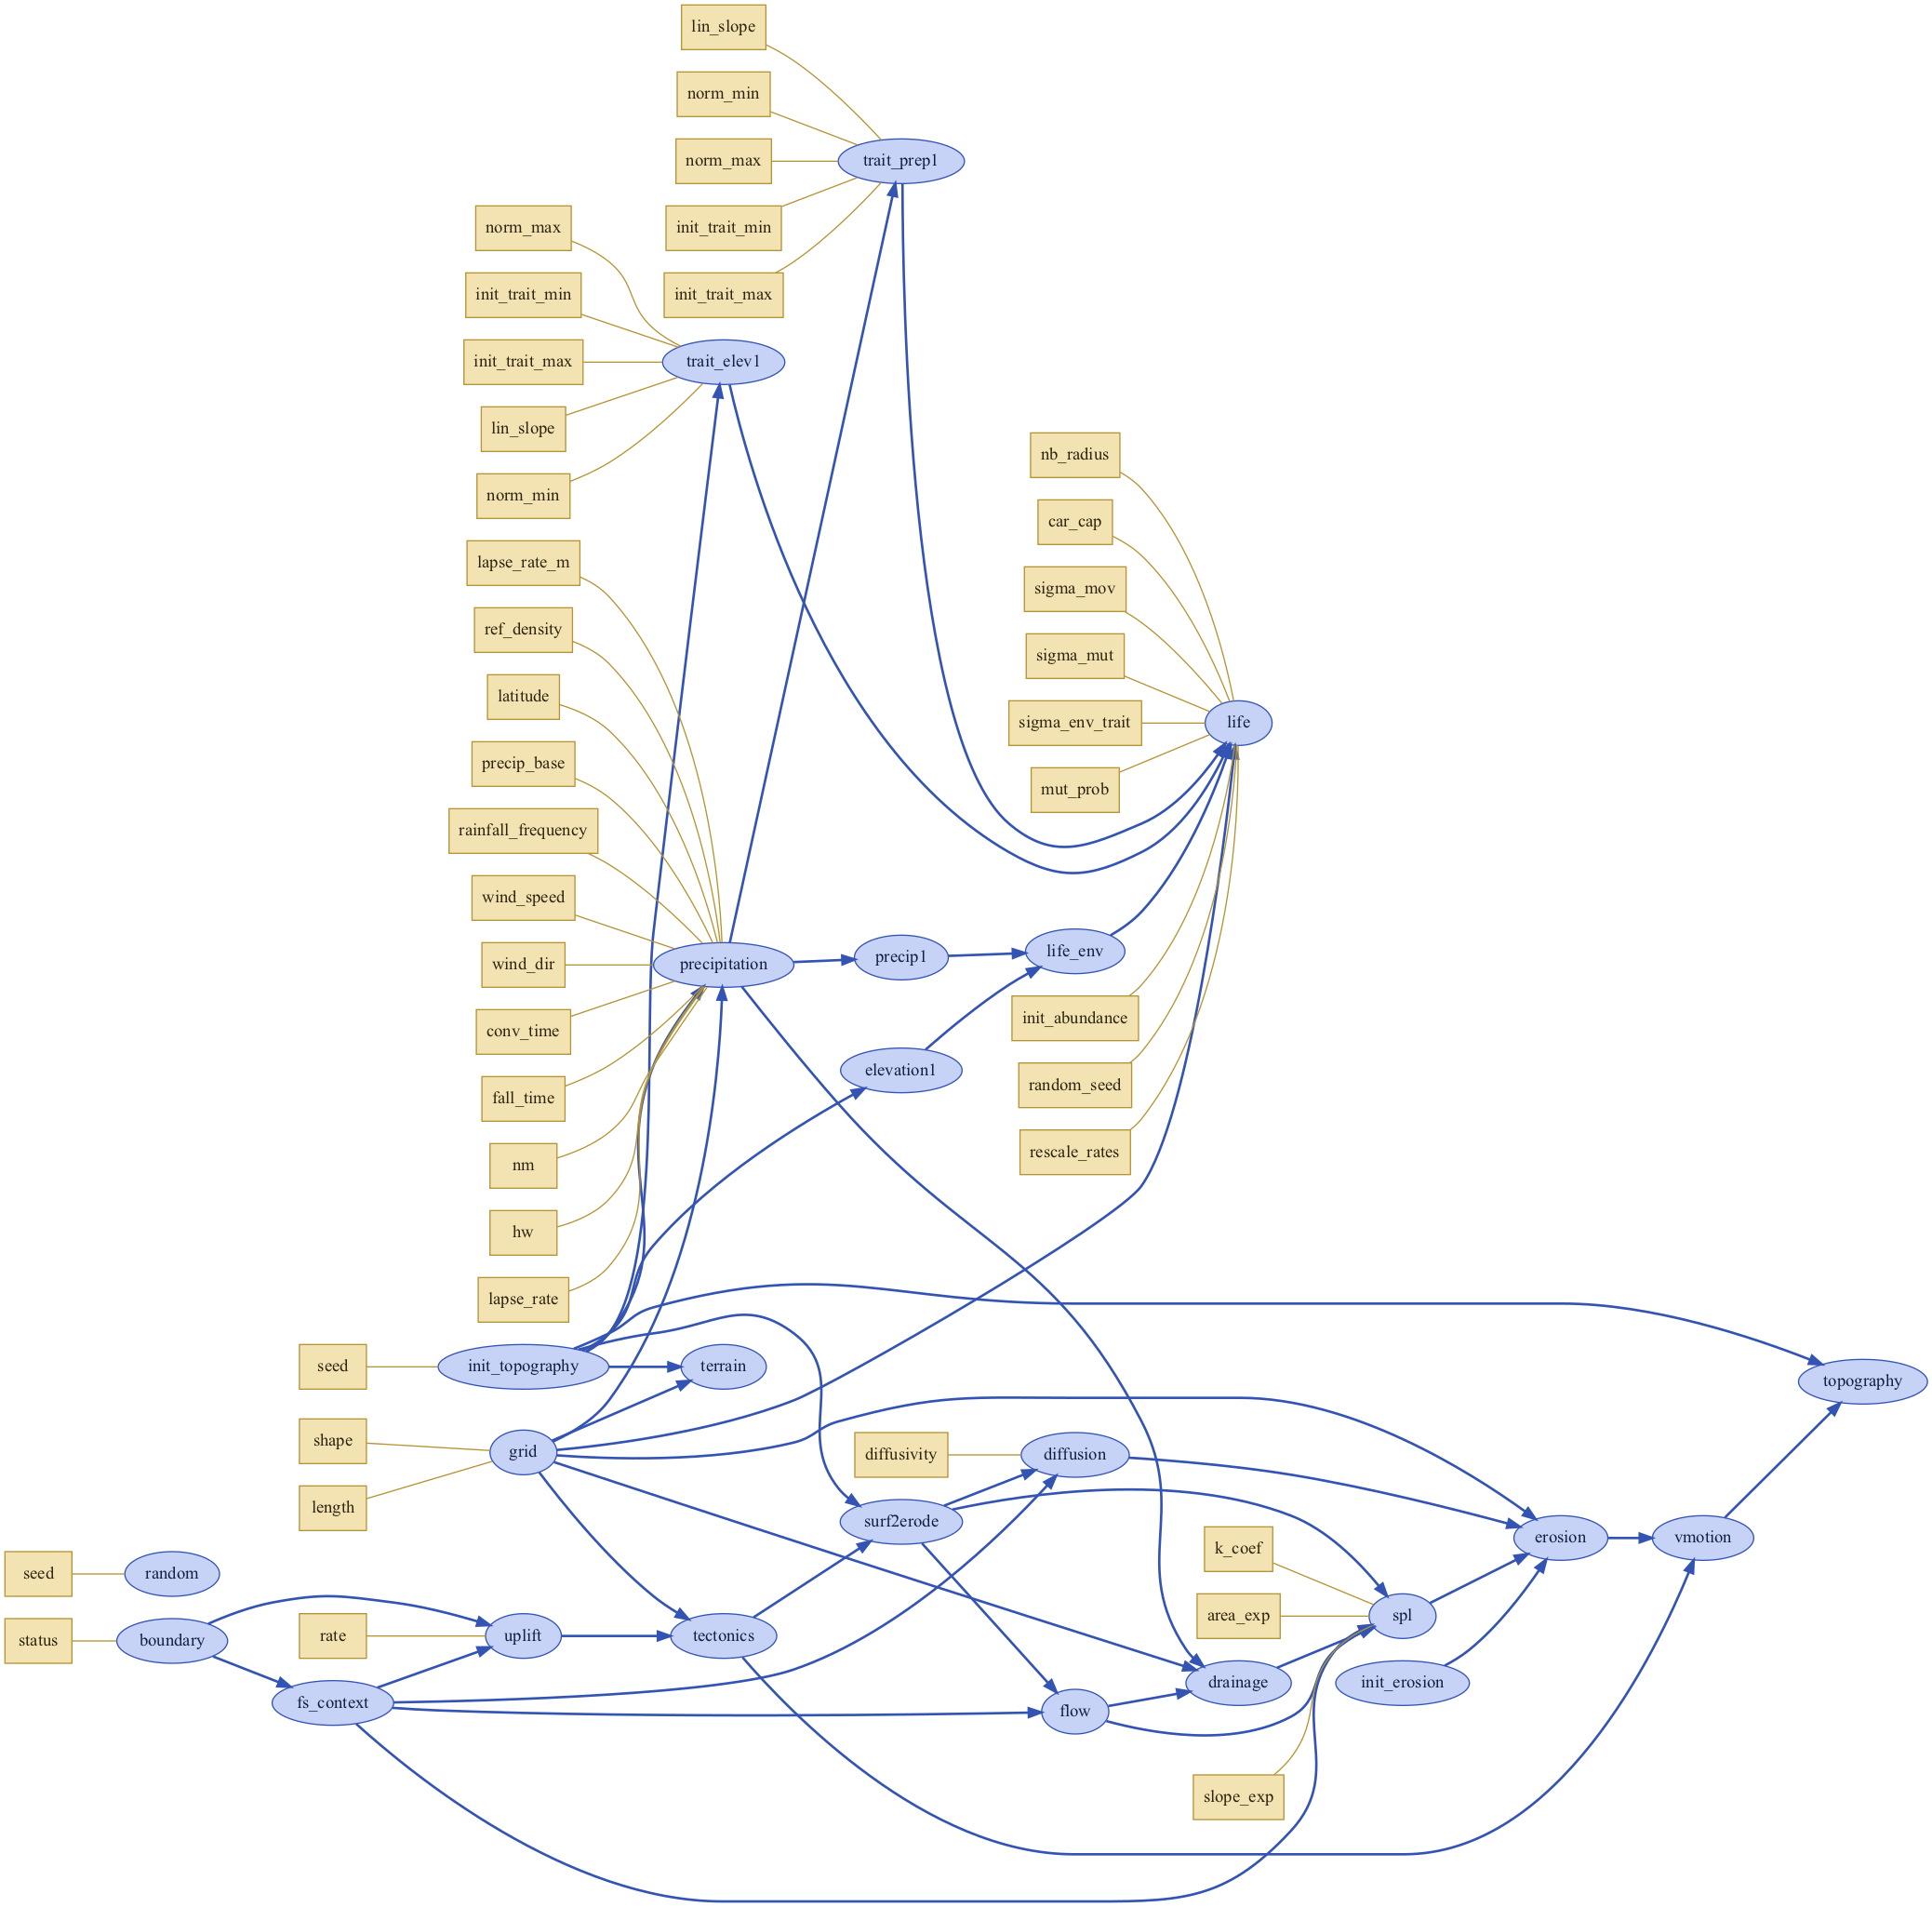

In [3]:
model.visualize(show_inputs=True)

In [4]:
random_seed = 1234
uplift_rate = 5e-3
hmax = 3500
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], 
        'grid__length': [1e5, 2e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': uplift_rate,
        'spl__k_coef': (uplift_rate/hmax)*50,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'diffusion__diffusivity': 3e-2,
        'init_topography__seed': random_seed,
        'random':{'seed': random_seed},
        'precipitation':{
            'rainfall_frequency':0.1,
            'latitude': 10, 
            'precip_base': 5,         
            'wind_speed': 10,          
            'wind_dir': 360,            
        },
        'trait_elev1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':hmax,
        },
        'trait_prep1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':7,
        },
        'life': {
            'init_abundance': 100,
            'nb_radius': 2e4,
            'car_cap': 25,
            'sigma_mov': 1000.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.5,
            'random_seed':random_seed
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'precipitation__precip_rate':'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [5]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

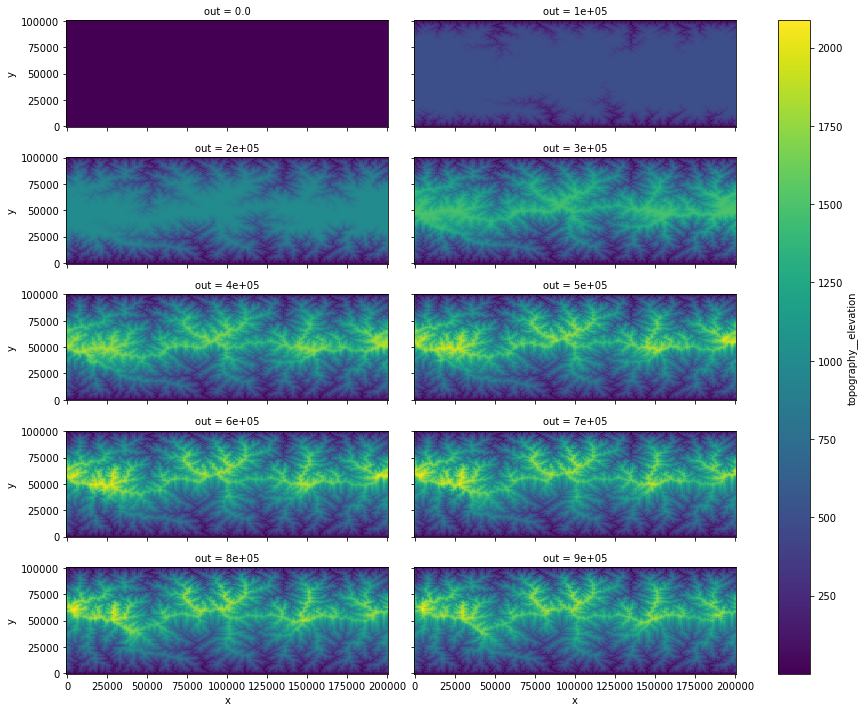

In [6]:
times = np.arange(0, 1e6, 1e5)
elev_max = out_ds.topography__elevation.max()
out_ds.sel(out=times).topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10))

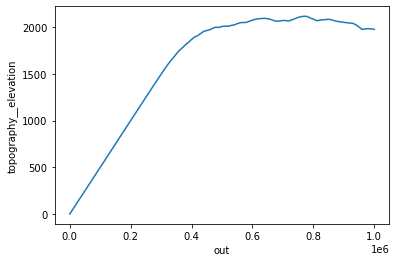

In [7]:
out_ds.topography__elevation.max(('x', 'y')).plot()

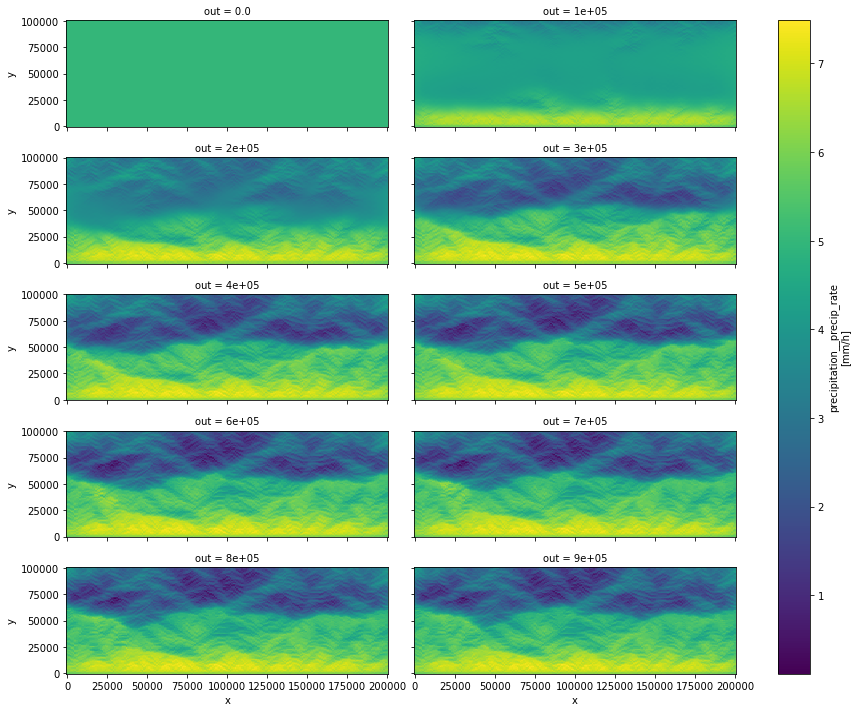

In [8]:
out_ds.sel(out=times).precipitation__precip_rate.plot(col='out', col_wrap=2, figsize=(13, 10))

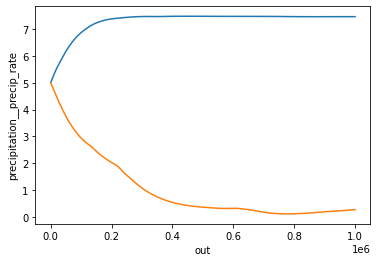

In [9]:
out_ds.precipitation__precip_rate.max(('x', 'y')).plot()
out_ds.precipitation__precip_rate.min(('x', 'y')).plot()

In [10]:
out_ds

<xarray.Dataset>
Dimensions:                            (border: 4, shape_yx: 2, out: 101,
                                        ind: 518, trait: 2, y: 101, x: 201,
                                        time: 1001)
Coordinates:
  * border                             (border) object 'left' ... 'bottom'
  * out                                (out) float64 0.0 1e+04 ... 9.9e+05 1e+06
  * time                               (time) float64 0.0 1e+03 ... 1e+06
  * x                                  (x) float64 0.0 1e+03 ... 1.99e+05 2e+05
  * y                                  (y) float64 0.0 1e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx, ind, trait
Data variables: (12/48)
    boundary__status                   (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity             float64 0.03
    grid__length                       (shape_yx) float64 1e+05 2e+05
    grid__shape                        (shape_yx) int64 101 201
    init_topography__seed              int64 1234
    life__ancestor_id                  (out, ind) float64 0.0 0.0 ... nan nan
    ...                                 ...
    trait_prep1__init_trait_max        float64 0.5
    trait_prep1__init_trait_min        float64 0.5
    trait_prep1__lin_slope             float64 0.95
    trait_prep1__norm_max              int64 7
    trait_prep1__norm_min              int64 0
    uplift__rate                       float64 0.005

In [11]:
individuals_data = {}
#reshape trait data
for i in range(out_ds.life__trait.shape[2]):
    individuals_data['life__trait_'+str(i)] = out_ds.life__trait[:,:,i]
out_ds=out_ds.assign(individuals_data)

In [12]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)

df

out  ind  ancestor_id  taxon_id              x             y  \
0            0.0    0          0.0       1.0  195339.953340  29784.009062   
1            0.0    1          0.0       1.0   76039.147004  61916.101637   
2            0.0    2          0.0       1.0  184649.246753  30175.742962   
3            0.0    3          0.0       1.0   52338.484773  17484.645113   
4            0.0    4          0.0       1.0   63819.411683  49550.519522   
...          ...  ...          ...       ...            ...           ...   
48222  1000000.0  505      13130.0   13325.0   16217.395657  21303.282676   
48223  1000000.0  506      13277.0   13418.0   16714.451526  28616.897602   
48224  1000000.0  507      13279.0   13420.0   13563.311263  12606.345533   
48225  1000000.0  508      13279.0   13420.0   11938.761714   9101.317747   
48226  1000000.0  509      13140.0   13378.0  145738.379597  76003.039570   

        trait_0   trait_1  
0      0.500000  0.500000  
1      0.500000  0.500000  
2      0.500000  0.500000  
3      0.500000  0.500000  
4      0.500000  0.500000  
...         ...       ...  
48222  0.598123  0.284672  
48223  0.762682  0.131456  
48224  0.836841  0.232166  
48225  0.876445  0.346251  
48226  0.385278  0.441809  

[48227 rows x 8 columns]

## Plot population

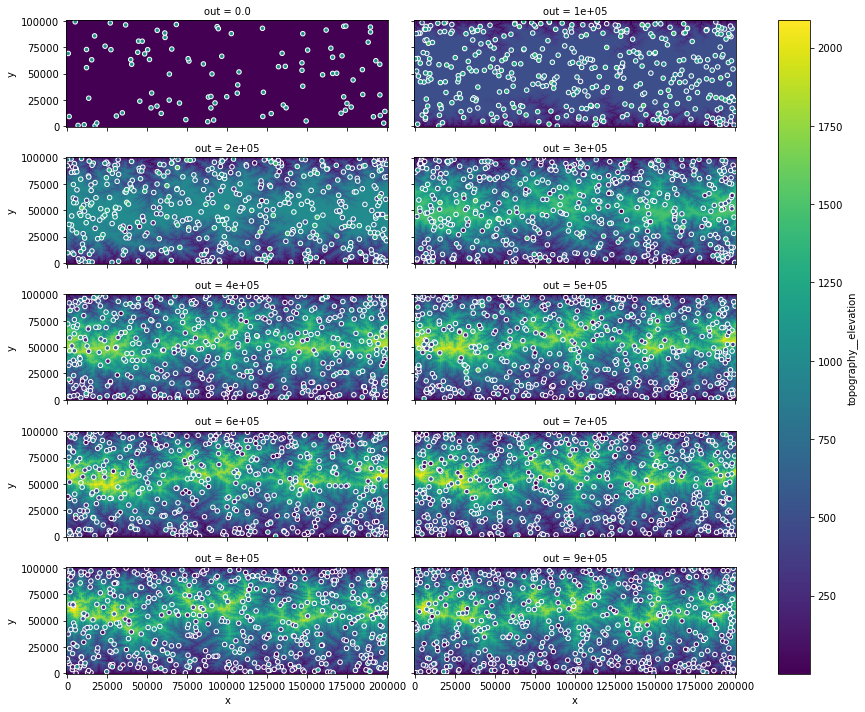

In [13]:
fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_1, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

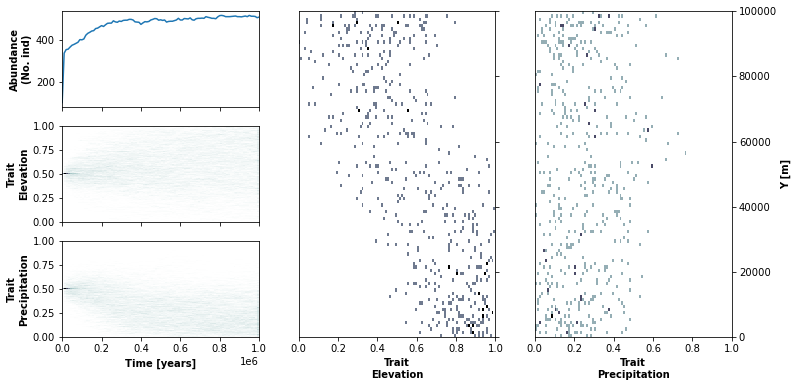

In [14]:
fig2, axs2 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, 1:].flatten():
    ax.remove()
axbig0 = fig2.add_subplot(gs2[0:, -2])
axbig1 = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df['out'], y=df['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig0.hist2d(x=df['trait_0'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig1.hist2d(x=df['trait_1'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
axbig0.yaxis.set_tick_params(labelleft=False)
axbig1.yaxis.set_label_position("right")
axbig0.yaxis.tick_right()
axbig1.yaxis.tick_right()
axbig0.set_xlabel('Trait\nElevation', weight='bold')
axbig1.set_xlabel('Trait\nPrecipitation', weight='bold')
axbig1.set_ylabel('Y [m]', weight='bold')
axs2[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs2[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs2[2,0].set_xlabel('Time [years]', weight='bold')

## Speciation with competition in an evolving landscape

In [15]:
model2 = model.update_processes({
    'life': DD03Speciation
})
model2

<xsimlab.Model (24 processes, 44 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
init_erosion
flow
precipitation
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] background, non-orographic precipit...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fal

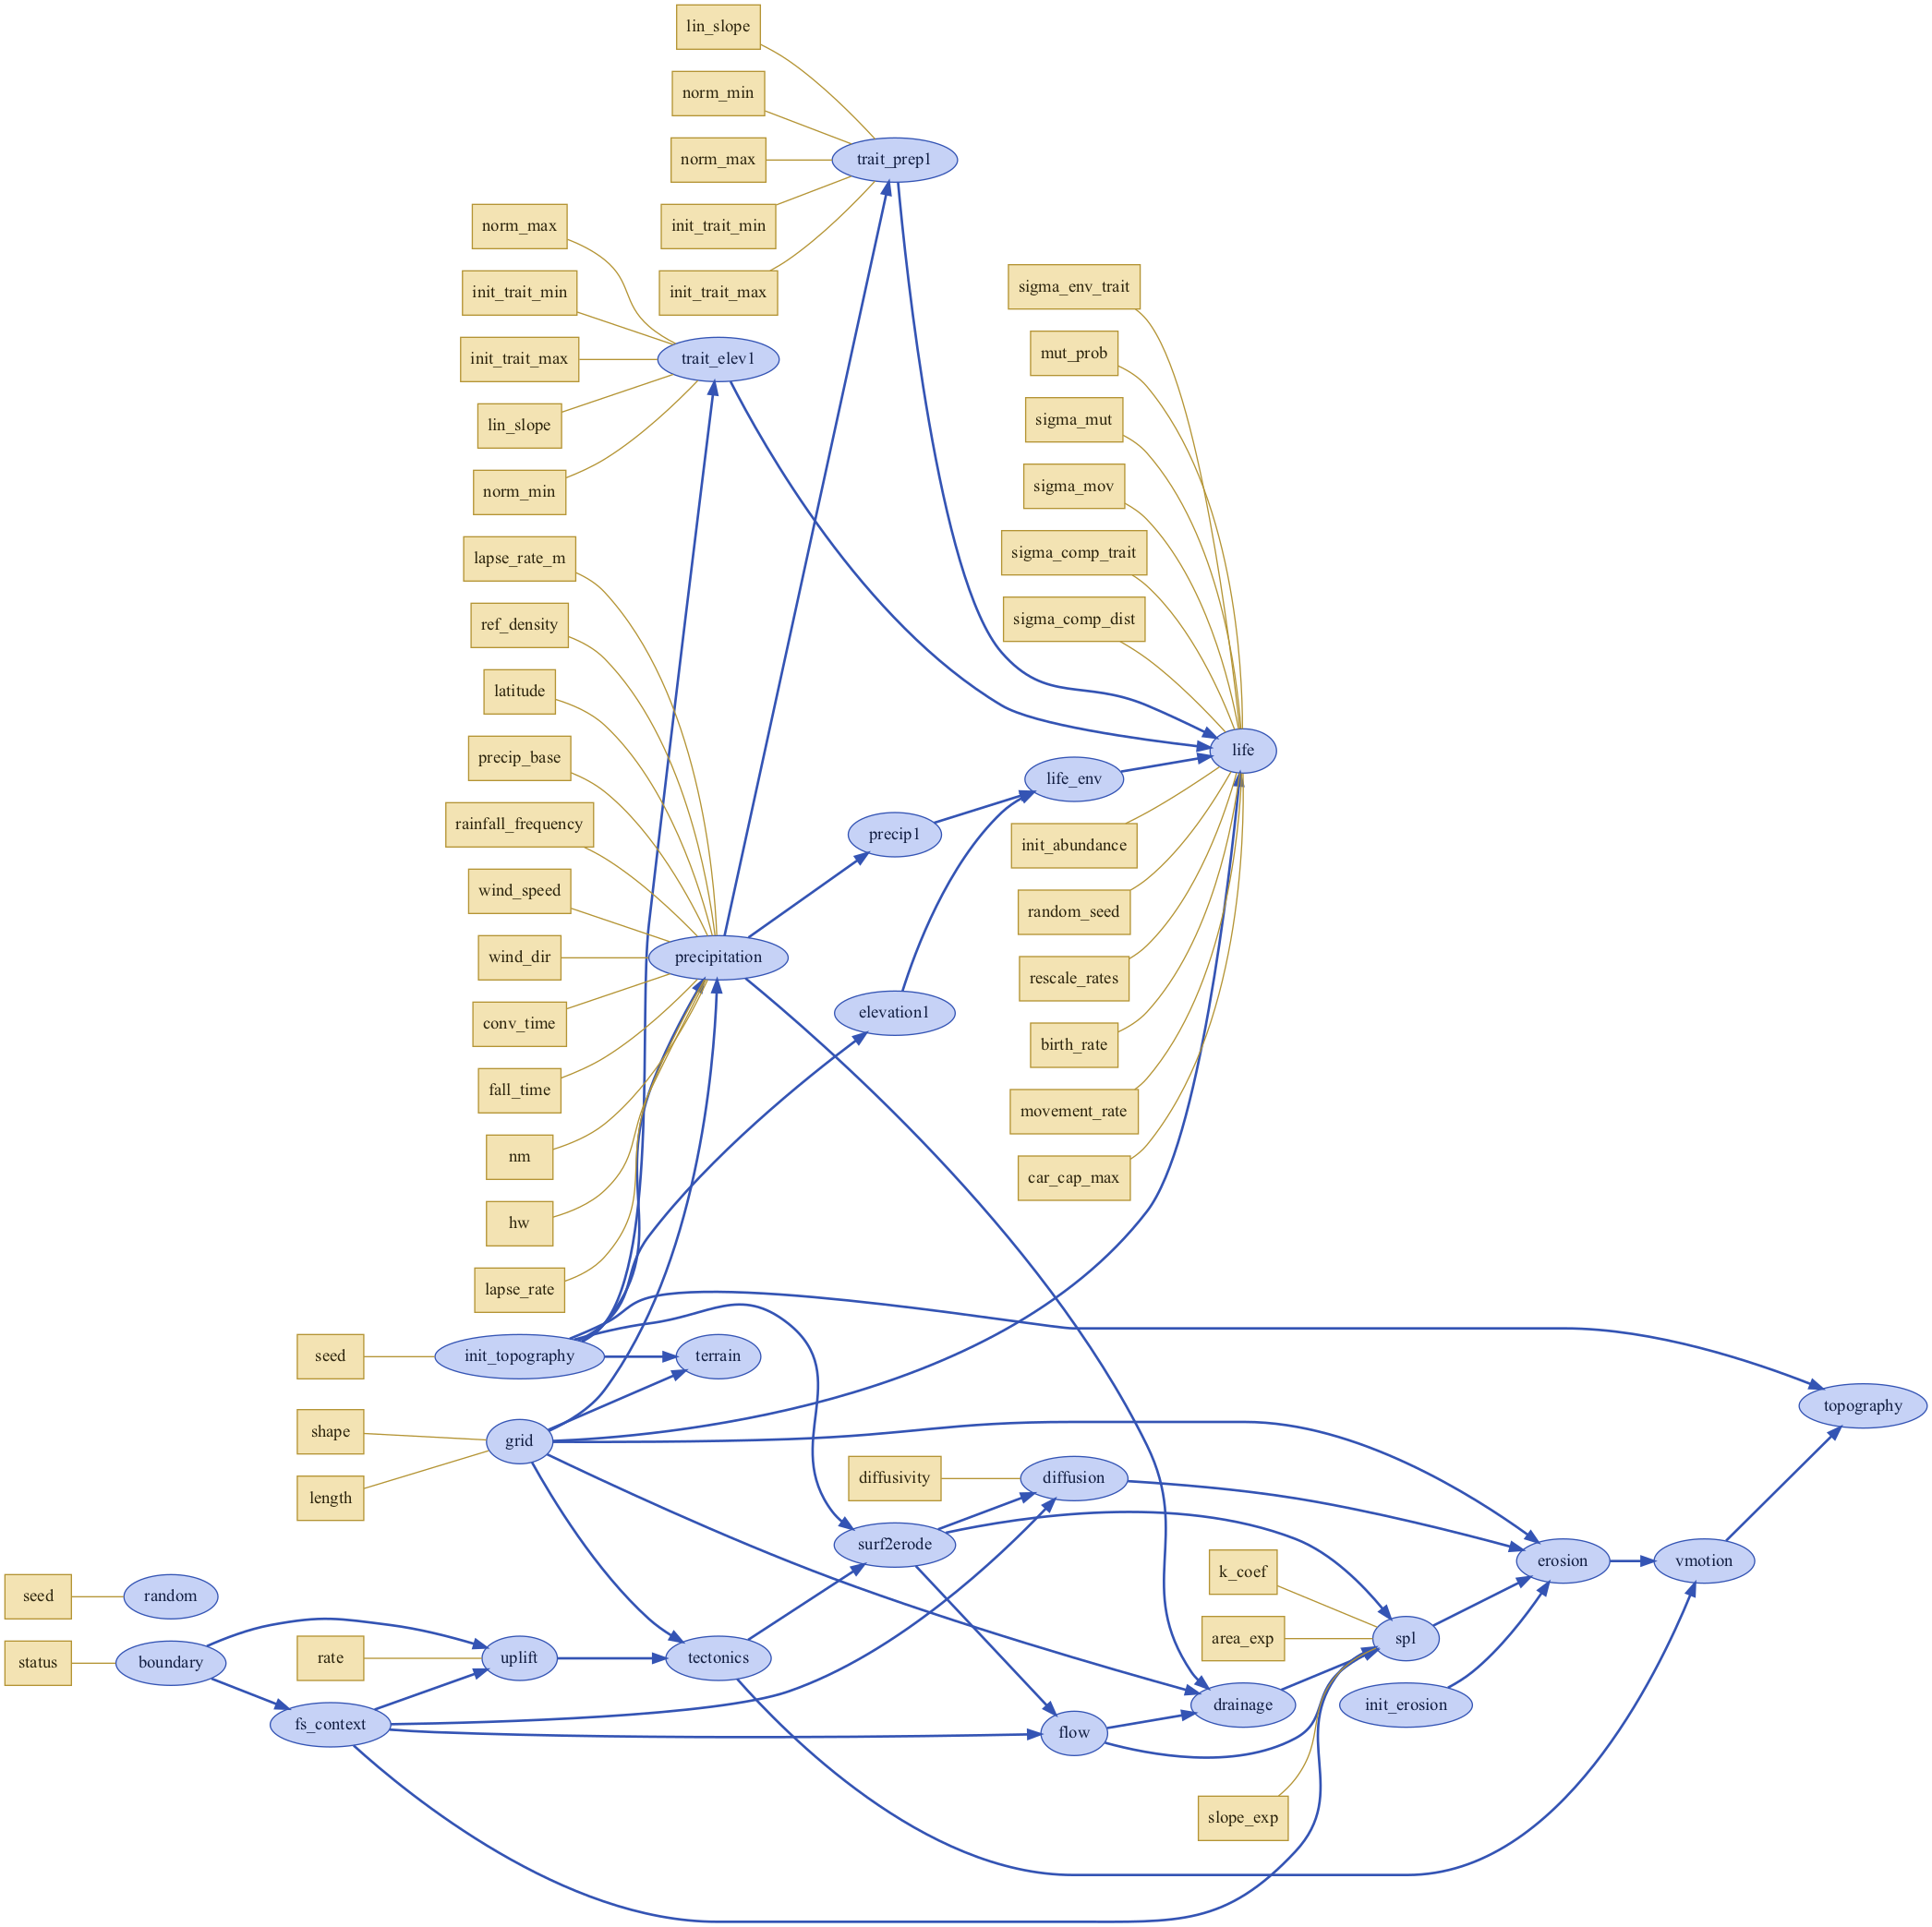

In [16]:
model2.visualize(show_inputs=True)

In [17]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], 
        'grid__length': [1e5, 2e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': uplift_rate,
        'spl__k_coef': (uplift_rate/hmax)*50,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'diffusion__diffusivity': 3e-2,
        'init_topography__seed': random_seed,
        'random':{'seed': random_seed},
        'precipitation':{
            'rainfall_frequency':0.1,
            'latitude': 10, 
            'precip_base': 5,         
            'wind_speed': 10,          
            'wind_dir': 360,            
        },
        'random':{'seed': random_seed},
        'trait_elev1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':hmax,
        },
        'trait_prep1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':7,
        },
        'life': {
            'init_abundance': 100,
            'birth_rate': 1.0,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_env_trait': 0.5,
            'sigma_comp_trait': 0.5,
            'sigma_comp_dist': 0.5,
            'random_seed': random_seed
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [18]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [19]:
individuals_data2 = {}
for i in range(out_ds2.life__trait.shape[2]):
    individuals_data2['life__trait_'+str(i)] = out_ds2.life__trait[:,:,i]
out_ds2=out_ds2.assign(individuals_data2)

In [20]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)


df2

out  ind  ancestor_id  taxon_id              x             y  \
0            0.0    0          0.0       1.0  195339.953340  29784.009062   
1            0.0    1          0.0       1.0   76039.147004  61916.101637   
2            0.0    2          0.0       1.0  184649.246753  30175.742962   
3            0.0    3          0.0       1.0   52338.484773  17484.645113   
4            0.0    4          0.0       1.0   63819.411683  49550.519522   
...          ...  ...          ...       ...            ...           ...   
49138  1000000.0  464      19512.0   19660.0  123753.067609  88325.047881   
49139  1000000.0  465      19509.0   19669.0    7148.054412  32967.426718   
49140  1000000.0  466      19509.0   19668.0    8234.476778  24202.635008   
49141  1000000.0  467      19509.0   19668.0    9511.673951  20153.979112   
49142  1000000.0  468      19509.0   19670.0   94117.136637  95733.183867   

        trait_0   trait_1  
0      0.500000  0.500000  
1      0.500000  0.500000  
2      0.500000  0.500000  
3      0.500000  0.500000  
4      0.500000  0.500000  
...         ...       ...  
49138  0.115143  0.316985  
49139  0.499139  0.600445  
49140  0.796754  0.077423  
49141  0.948690  0.405425  
49142  0.101521  0.084570  

[49143 rows x 8 columns]

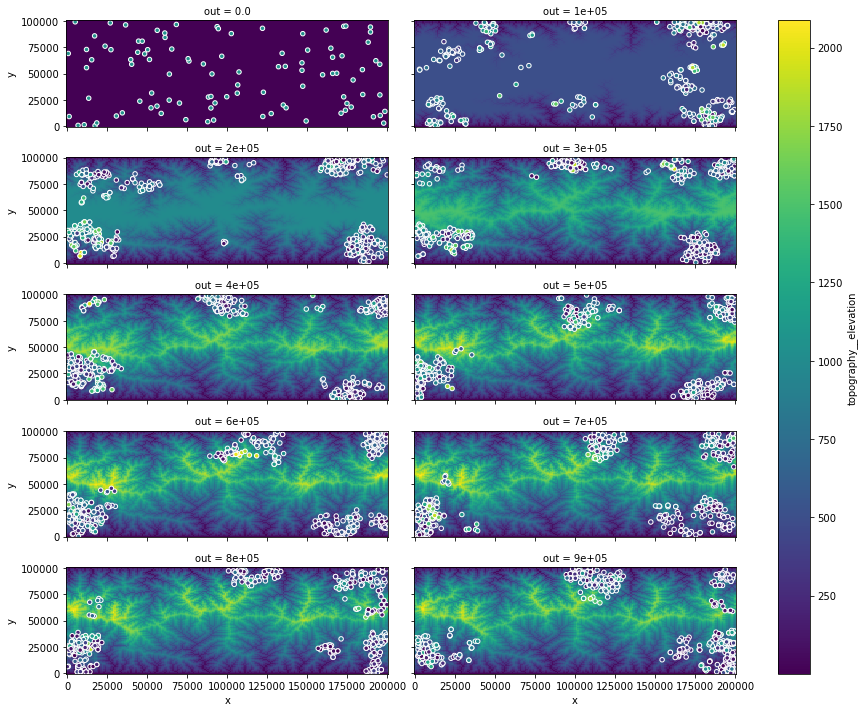

In [21]:
fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_1, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

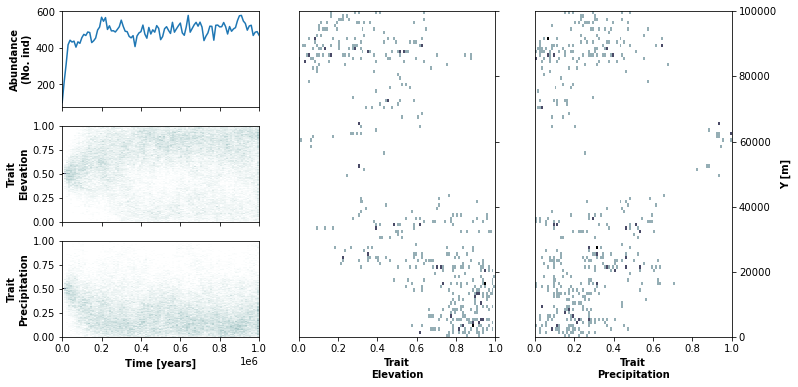

In [22]:
fig5, axs5 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, 1:].flatten():
    ax.remove()
ax5big0 = fig5.add_subplot(gs5[0:, -2])
ax5big1 = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big0.hist2d(x=df2['trait_0'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big1.hist2d(x=df2['trait_1'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax5big0.yaxis.set_tick_params(labelleft=False)
ax5big1.yaxis.set_label_position("right")
ax5big0.yaxis.tick_right()
ax5big1.yaxis.tick_right()
ax5big0.set_xlabel('Trait\nElevation', weight='bold')
ax5big1.set_xlabel('Trait\nPrecipitation', weight='bold')
ax5big1.set_ylabel('Y [m]', weight='bold')
axs5[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs5[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs5[2,0].set_xlabel('Time [years]', weight='bold')